In [1]:
%load_ext autoreload
%autoreload 2
%load_ext autotime

In [6]:
import sys
sys.path.append('../src')
from main import load_data
from preprocessing import clean_text, remove_stop_words, negation_handling, lemmatizing, emoji_tagging
from features_extractor import Extractor, extract_tf, extract_tf_idf, extract_sentiment

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_selection import SelectKBest, chi2

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score
from util import curry, load_features_from_file
from pprint import pprint

import matplotlib.pyplot as plt
import copy

time: 2.35 ms


In [3]:
Xtr_text, Ytr, Xte_text, Yte = load_data('../aclImdb/train/', '../aclImdb/test/')

Load Data...
Done loading data!

time: 24.2 s


In [20]:
ngram_range = (1,1)
min_df=2
max_df=0.5
n_features=10000

time: 2.28 ms


In [21]:
Xtr, Xte = Extractor(Xtr_text, Xte_text)\
        .bind(curry(emoji_tagging))\
        .bind(curry(remove_stop_words))\
        .bind(curry(lemmatizing))\
        .bind(curry(negation_handling))\
        .bind(curry(clean_text))\
        .bind(extract_tf(ngram_range=ngram_range, min_df=min_df,max_df=max_df))\
        .bind(extract_tf_idf)\
        .get_features()

time: 7min 51s


In [22]:
def lsa(Xtr, Xte, n_components):
    svd = TruncatedSVD(n_components)
    lsa = make_pipeline(svd, Normalizer(copy=False))

    lsa.fit(Xtr)
    Xtr_lsa = lsa.transform(Xtr)
    Xte_lsa = lsa.transform(Xte)

    return Xtr_lsa, Xte_lsa
    
def k_best(Xtr, Ytr, Xte, Yte, k_best):
    Select = SelectKBest(chi2, k=k_best).fit(Xtr, Ytr)
    XtrS = Select.transform(Xtr)
    XteS = Select.transform(Xte)
    
    return XtrS, XteS

def run_classifier(Xtr, Ytr, Xte, Yte):
    classifier = LogisticRegression(solver='lbfgs')
    classifier.fit(Xtr, Ytr)
    Yte_hat = classifier.predict(Xte)

    f1 = f1_score(Yte, Yte_hat)
    p = precision_score(Yte, Yte_hat)
    r = recall_score(Yte, Yte_hat)
    return [f1, p, r]

time: 2.78 ms


In [24]:
n_features = [1, 10, 100, 1000]
labels = ["LSA", "K-Best"]
f1_scores_k = []
p_scores_k = []
r_scores_k  = []

f1_scores_lsa = []
p_scores_lsa = []
r_scores_lsa  = []

for k in n_features:
    print(k)
    Xtr_k, Xte_k = k_best(Xtr, Ytr, Xte, Yte, k)
    Xtr_lsa, Xte_lsa = lsa(Xtr, Xte, k)

    scores_k = run_classifier(Xtr_k, Ytr, Xte_k, Yte)
    scores_lsa = run_classifier(Xtr_lsa, Ytr, Xte_lsa, Yte)

    f1_scores_k.append(scores_k[0])
    p_scores_k.append(scores_k[1])
    r_scores_k.append(scores_k[2])

    f1_scores_lsa.append(scores_lsa[0])
    p_scores_lsa.append(scores_lsa[1])
    r_scores_lsa.append(scores_lsa[2])


1


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


10
100
1000
time: 1min 33s


In [ ]:
print("start best k")
Xtr_k, Xte_k = k_best(Xtr, Ytr, Xte, Yte, 10000)
print("start lsa")
Xtr_lsa, Xte_lsa = lsa(Xtr, Xte, 10000)

scores_k = run_classifier(Xtr_k, Ytr, Xte_k, Yte)
scores_lsa = run_classifier(Xtr_lsa, Ytr, Xte_lsa, Yte)

f1_scores_k.append(scores_k[0])
p_scores_k.append(scores_k[1])
r_scores_k.append(scores_k[2])

f1_scores_lsa.append(scores_lsa[0])
p_scores_lsa.append(scores_lsa[1])
r_scores_lsa.append(scores_lsa[2])

start best k
start lsa


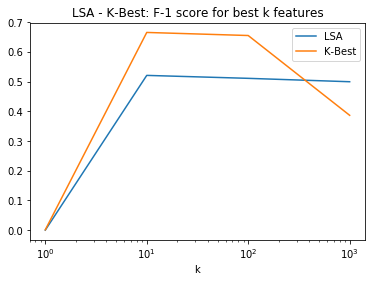

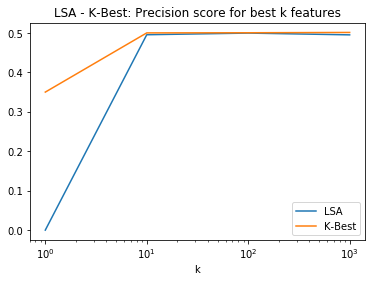

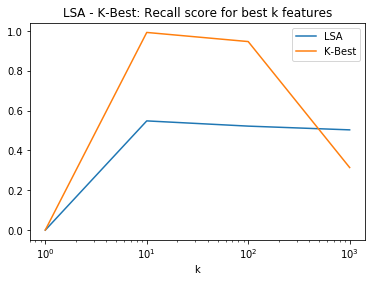

time: 1.75 s


In [26]:
plt.semilogx(n_features, f1_scores_lsa)
plt.semilogx(n_features, f1_scores_k)
plt.title("LSA - K-Best: F-1 score for best k features")
plt.legend(labels)
plt.xlabel("k")
plt.savefig('f1-score-lsa-k.png', bbox_inches='tight')
plt.show()
    
    
plt.semilogx(n_features, p_scores_lsa)
plt.semilogx(n_features, p_scores_k)
plt.title("LSA - K-Best: Precision score for best k features")
plt.legend(labels)
plt.xlabel("k")
plt.savefig('p-score-lsa-k.png', bbox_inches='tight')
plt.show()

plt.semilogx(n_features, r_scores_lsa)
plt.semilogx(n_features, r_scores_k)
plt.title("LSA - K-Best: Recall score for best k features")
plt.legend(labels)
plt.xlabel("k")
plt.savefig('r-score-lsa-k.png', bbox_inches='tight')
plt.show()